# Задание 3.

Загрузите [данные по изменению температуры поверхности земли](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data). Для этого может понадобится зарегистрироваться на [Kaggle](https://kaggle.com). Затем нужно будет работать с данными, которые содержатся в файле **GlobalLandTemperaturesByMajorCity.csv**

In [1]:
import zipfile

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_theme()

with zipfile.ZipFile("archive.zip") as z:
    with z.open("GlobalLandTemperaturesByMajorCity.csv") as f:
        df = pd.read_csv(f, parse_dates=["dt"])

df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


# Задание 3.1 (1 балл)

В последующих заданиях будут учитываться данные начиная с 01.01.1950. Для этого создайте новый `DataFrame`, в котором удалены все строки до 01.01.1950. Используйте созданный DataFrame в последующих заданиях.  

In [2]:
df["dt"] = pd.to_datetime(df["dt"], yearfirst=True)
df = df.loc[df["dt"] > "1950-01-01"]
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
1213,1950-02-01,27.527,0.348,Abidjan,Côte D'Ivoire,5.63N,3.23W
1214,1950-03-01,28.344,0.431,Abidjan,Côte D'Ivoire,5.63N,3.23W
1215,1950-04-01,27.830,0.467,Abidjan,Côte D'Ivoire,5.63N,3.23W
1216,1950-05-01,26.896,0.248,Abidjan,Côte D'Ivoire,5.63N,3.23W
1217,1950-06-01,25.454,0.209,Abidjan,Côte D'Ivoire,5.63N,3.23W


# Задание 3.2 (2 балла)

Постройте график среднегодовых температур в городе Торонто.

<AxesSubplot: xlabel='dt'>

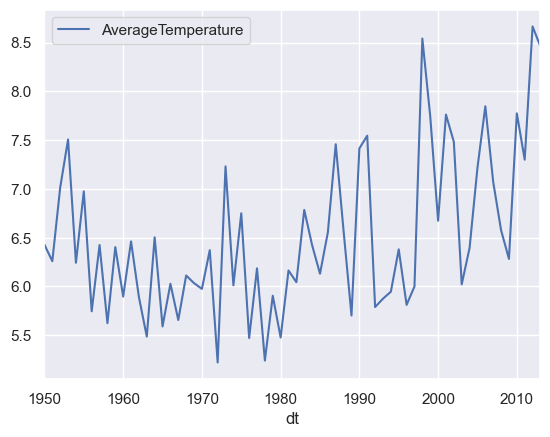

In [3]:
df.loc[df["City"] == "Toronto", ["dt", "AverageTemperature"]].groupby(pd.Grouper(key="dt", freq="Y")).mean().plot()

# Задание 3.3 (2 балла)

Найдите город, для которого выборочная дисперсия температур на приведенных данных максимальна. 

In [4]:
df.loc[:, ["City", "AverageTemperature"]].groupby("City", dropna=True).var().sort_values(by="AverageTemperature", ascending=False).iloc[0].name

'Harbin'

# Задание 3.4 (4 балла)

На одной оси постройте графики, отображающие:
1. Зависимость выборочной дисперсии температур от широты города (Latitude).
2. Зависимость средней температуры в январе 1975 года от широты города (Latitude).
3. Зависимость средней температуры в июле 1975 года от широты города (Latitude).

Присвоим северным широтам полжительные значения, а южным - отрицательные.

In [5]:
df.loc[:, "Latitude_Int"] = df["Latitude"].apply(lambda x: float(x[:-1]) if x[-1] == "N" else -float(x[:-1]))

<AxesSubplot: xlabel='Latitude_Int'>

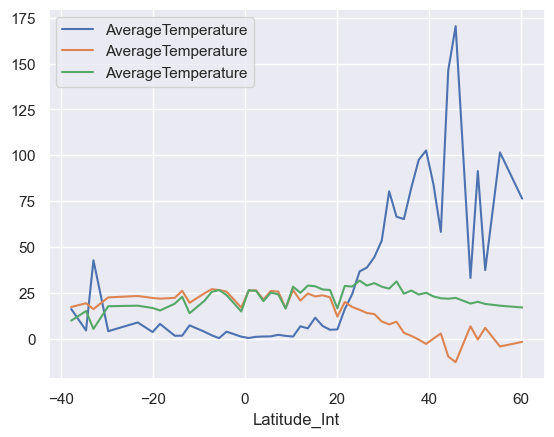

In [6]:
ax = df.loc[:, ["Latitude_Int", "AverageTemperature"]].groupby("Latitude_Int").var().plot()
df.loc[(df["dt"].dt.year == 1975) & (df["dt"].dt.month == 1), ["Latitude_Int", "AverageTemperature"]].groupby("Latitude_Int").mean().plot(ax=ax)
df.loc[(df["dt"].dt.year == 1975) & (df["dt"].dt.month == 7), ["Latitude_Int", "AverageTemperature"]].groupby("Latitude_Int").mean().plot(ax=ax)

# Задание 3.5 (6 баллов)

Посчитайте данные по среднегодовой температуре в Санкт-Петербурге. Определите года, в которых средняя температура была выше, чем в предыдущем  и последующем году. Постройте график среднегодовой температуры и обозначьте на нём найденные года (произвольным образом). 

Постройте модель линейной регрессии (можно использовать [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)): $\mathbb{год} \rightarrow \mathbb{средняя\_температура}$. Отобразите прямую на предыдущем графике. 

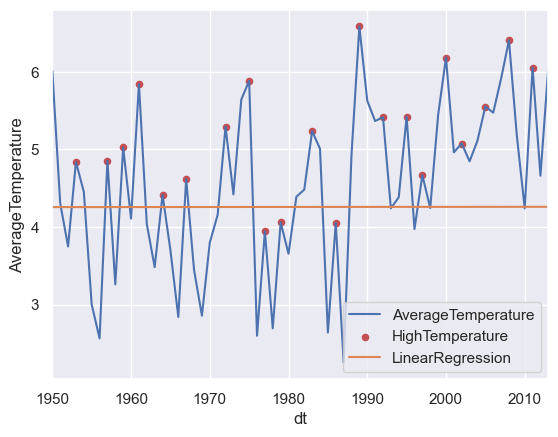

In [7]:
from sklearn.linear_model import LinearRegression

avg_tmp = df.loc[df["City"] == "Saint Petersburg", ["dt", "AverageTemperature"]].groupby(pd.Grouper(key="dt", freq="Y")).mean()

high_tmp = avg_tmp.loc[(((avg_tmp["AverageTemperature"] - avg_tmp["AverageTemperature"].shift(periods=-1)) > 0) & \
    ((avg_tmp["AverageTemperature"] - avg_tmp["AverageTemperature"].shift(periods=1)) > 0))]

lr = LinearRegression()
lr.fit(np.reshape(avg_tmp.index.year, (-1, 1)), avg_tmp["AverageTemperature"])
pred_temp = lr.predict(np.reshape(avg_tmp.index.year, (-1, 1)))

fig, ax = plt.subplots()
avg_tmp.plot(ax=ax)
# ax.plot(high_tmp.index, high_tmp["AverageTemperature"], 'ro', label="HighTemperature")
high_tmp.reset_index().plot("dt", "AverageTemperature", color="r", kind="scatter", ax=ax, label="HighTemperature")
ax.plot(avg_tmp.index, pred_temp, label="LinearRegression")
ax.legend()

# Задание 3.6 (4 балла)

Найдите города, для которых: 
1. Разница между максимальным и минимальным значением среднегодовой температуры в выборке максимальна.
2. Самая большая средняя разница между средней температурой января и средней температурой июля.
3. Наибольшее среднее количество месяцев с отрицательной температурой в году.

##### 1. Разница между максимальным и минимальным значением среднегодовой температуры в выборке максимальна.

In [8]:
mean_temp_year = df[["dt", "City", "AverageTemperature"]].groupby(["City", pd.Grouper(key="dt", freq="Y")],).mean()
city1 = (mean_temp_year.groupby("City").max() - mean_temp_year.groupby("City").min())["AverageTemperature"].idxmax()
city1

'Mashhad'

##### 2. Самая большая средняя разница между средней температурой января и средней температурой июля.

In [9]:
temp_df = df[["dt", "City", "AverageTemperature"]]
temp_df["Month"] = df["dt"].dt.month
temp_grouped_df = temp_df[["City", "Month", "AverageTemperature"]].groupby(["City", "Month"]).mean().reset_index()
jan_temp_df = temp_grouped_df.loc[temp_grouped_df["Month"] == 1].set_index("City")
jul_temp_df = temp_grouped_df.loc[temp_grouped_df["Month"] == 7].set_index("City")
(jul_temp_df["AverageTemperature"] - jan_temp_df["AverageTemperature"]).abs().idxmax()

C:\Users\maslo\AppData\Local\Temp\ipykernel_21200\1654206707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["Month"] = df["dt"].dt.month


'Harbin'

##### 3. Наибольшее среднее количество месяцев с отрицательной температурой в году.

In [10]:
month_count = df.loc[df["AverageTemperature"] < 0, ["City", "AverageTemperature"]].groupby("City").count()
month_count["AverageTemperature"].idxmax()

'Harbin'

# Задание 3.7 (3 балла)

Отобразите города на карте, например с помощью [geopandas/folium](https://geopandas.org/en/stable/gallery/plotting_with_folium.html) или [plotly](https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo.html). Причем цвет метки должен соответствовать средней температуре в январе за последние 10 лет. 


**\***(+3 балла). Вычислите прямую с "трендом" по изменению средней температуры за год в каждом городе в период 1950-2013 (можно с помощью линейной регрессии, как в задании **3.5**). Отобразите города цветом, который зависит от угла наклона этой прямой. 


**\***(+1 балл) В дополнение к предыдущему пункту, используйте библиотеку [pwlf](https://pypi.org/project/pwlf/) с фиксированным числом сегментов и визуализируйте угол наклона последнего сегмента. 

In [16]:
import geopandas as gpd

df_new = df[["dt", "AverageTemperature", "City", "Country", "Latitude", "Longitude"]].copy(deep=True)
df_new["Latitude"] = df_new["Latitude"].apply(lambda x: float(x[:-1]) if x[-1] == "N" else -float(x[:-1]))
df_new["Longitude"] = df_new["Longitude"].apply(lambda x: float(x[:-1]) if x[-1] == "E" else -float(x[:-1]))
geometry = gpd.points_from_xy(df_new["Latitude"], df_new["Longitude"])
geo_df = gpd.GeoDataFrame(df_new, geometry=geometry)
geo_df.head()

,dt,AverageTemperature,City,Country,Latitude,Longitude,geometry
1213,1950-02-01,27.527,Abidjan,Côte D'Ivoire,5.63,-3.23,POINT (5.63000 -3.23000)
1214,1950-03-01,28.344,Abidjan,Côte D'Ivoire,5.63,-3.23,POINT (5.63000 -3.23000)
1215,1950-04-01,27.830,Abidjan,Côte D'Ivoire,5.63,-3.23,POINT (5.63000 -3.23000)
1216,1950-05-01,26.896,Abidjan,Côte D'Ivoire,5.63,-3.23,POINT (5.63000 -3.23000)
1217,1950-06-01,25.454,Abidjan,Côte D'Ivoire,5.63,-3.23,POINT (5.63000 -3.23000)


In [ ]:
import plotly.express as px

px.scatter_geo(df,
               lat = df["Latitude"],
               lon = df["Longitude"],
               )

# *Задание 3.8 (8 баллов)

Цель - создать проект, который как минимум включает:
1. Использование юнит-тестов ([pytest](https://pytest.org)).
2. Применение средств форматирования и проверки исходного кода (например: [isort](https://pycqa.github.io/isort/), [black](https://black.readthedocs.io/en/stable/), [flake8](https://flake8.pycqa.org/en/latest/), [mypy](https://mypy.readthedocs.io/en/stable/)).
3. Спецификацию проекта в [pyproject.toml](https://pip.pypa.io/en/stable/reference/build-system/pyproject-toml/).
4. Использование утилит для работы с командной строкой ([argparse](https://docs.python.org/3/library/argparse.html), [click](https://click.palletsprojects.com/en/8.1.x/) и т.п.)
5. Сборку проекта в Wheel-файл.

Проект должен быть загружен в репозиторий. Функционал - произвольный, но должны использоваться данные из этого домашнего задания. Сам файл передается в качестве первого аргумента командной строки.  Например:

> python3 -m homeproject.app GlobalLandTemperaturesByMajorCity.csv 1980

Выдает самый жаркий месяц и город по наблюдениям за 1980 год.

*Ссылка на проект*